In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from modAL.models import ActiveLearner
from modAL.models import uncertainty_sampling

In [2]:
train_mols = [ m for m in Chem.SDMolSupplier("solubility.train.sdf") if m != None ]
test_mols =  [ m for m in Chem.SDMolSupplier("solubility.test.sdf") if m != None ]

In [3]:
len(train_mols)

1025

In [4]:
print(list(train_mols[0].GetPropNames()))

['ID', 'NAME', 'SOL', 'SOL_classification', 'smiles']


In [5]:
def mol2fp(mol):
    arr = np.zeros(0,)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

trainX = np.array([mol2fp(mol) for mol in train_mols])
testX = np.array([mol2fp(mol) for mol in test_mols])

In [6]:
clses = list(set(train_mols[i].GetProp("SOL_classification") for i in range(len(train_mols))))
print(clses)

['(C) high', '(B) medium', '(A) low']


In [7]:
le = LabelEncoder()
le.fit(clses)

LabelEncoder()

In [8]:
trainy = le.fit_transform([m.GetProp("SOL_classification") for m in train_mols]).ravel()
testy = le.fit_transform([m.GetProp("SOL_classification") for m in test_mols]).ravel()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def train_and_mapper(classifier, traindata, testdata):
    classifier.fit(traindata[0], traindata[1])
    pred = classifier.predict(testdata[0])
    print(classification_report(testdata[1], pred))
    conf_mat = confusion_matrix(testdata[1], pred)
    print(conf_mat)
    norm_conf_mat = conf_mat/np.sum(conf_mat, axis=1)
    plt.imshow(norm_conf_mat, cmap=plt.cm.Blues)
    plt.colorbar()
    

             precision    recall  f1-score   support

          0       0.72      0.78      0.75       102
          1       0.71      0.60      0.65       115
          2       0.57      0.70      0.63        40

avg / total       0.69      0.69      0.69       257

[[80 16  6]
 [31 69 15]
 [ 0 12 28]]


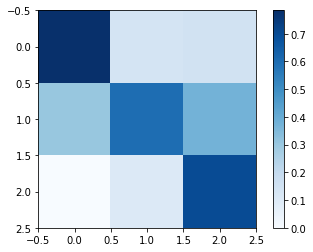

In [11]:
rfc = RandomForestClassifier()
train_and_mapper(rfc, [trainX, trainy], [testX, testy])

             precision    recall  f1-score   support

          0       0.72      0.74      0.73       102
          1       0.68      0.60      0.64       115
          2       0.51      0.65      0.57        40

avg / total       0.67      0.66      0.66       257

[[75 21  6]
 [27 69 19]
 [ 2 12 26]]


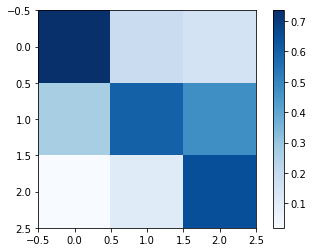

In [12]:
gpc = GaussianProcessClassifier()
train_and_mapper(gpc, [trainX, trainy], [testX, testy])

             precision    recall  f1-score   support

          0       0.75      0.75      0.75       102
          1       0.72      0.70      0.71       115
          2       0.70      0.78      0.74        40

avg / total       0.73      0.73      0.73       257

[[77 22  3]
 [25 80 10]
 [ 0  9 31]]


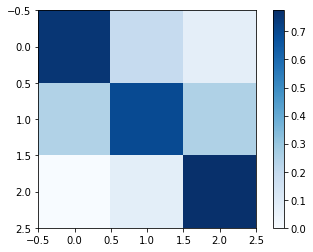

In [13]:
svc = SVC(C=100)
train_and_mapper(svc, [trainX, trainy], [testX, testy])

In [14]:
np.random.seed(794)
sampling_n = 10
init_idx = np.random.choice(len(trainX), sampling_n, replace=False )

In [15]:
initX, inity = trainX[init_idx], trainy[init_idx]

In [16]:
learner = ActiveLearner(
                                         estimator=RandomForestClassifier(),
                                         X_training=initX,
                                         y_training=inity,
                                         query_strategy=uncertainty_sampling)

In [17]:
# init10 samples +10 samples x 51 steps = 520 samples for learning
n_learn = 20
for i in range(n_learn):
    query_idx, query_instance = learner.query(trainX, n_instances=10)
    learner.teach(X = trainX[query_idx], y = trainy[query_idx])
    if i % 10 == 0:
        print('{} th learning result'.format(i))
        print(classification_report(testy, learner.predict(testX)))

    

0 th learning result
             precision    recall  f1-score   support

          0       0.45      0.49      0.47       102
          1       0.44      0.28      0.34       115
          2       0.31      0.57      0.40        40

avg / total       0.43      0.41      0.40       257

10 th learning result
             precision    recall  f1-score   support

          0       0.65      0.51      0.57       102
          1       0.53      0.72      0.61       115
          2       0.48      0.25      0.33        40

avg / total       0.57      0.56      0.55       257



In [18]:
al_pred = learner.predict(testX)

             precision    recall  f1-score   support

          0       0.69      0.55      0.61       102
          1       0.56      0.73      0.64       115
          2       0.44      0.30      0.36        40

avg / total       0.60      0.59      0.58       257

[[56 40  6]
 [22 84  9]
 [ 3 25 12]]


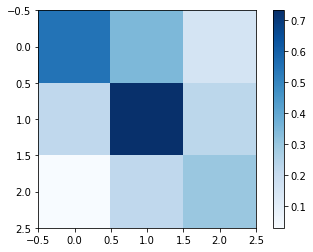

In [19]:
print(classification_report(testy, al_pred))
conf_mat = confusion_matrix(testy, al_pred)
print(conf_mat)
norm_conf_mat = conf_mat/np.sum(conf_mat, axis=1)
plt.imshow(norm_conf_mat, cmap=plt.cm.Blues)
plt.colorbar()

In [20]:
print(len(trainy[trainy==0])/len(trainy))
print(len(trainy[trainy==1])/len(trainy))
print(len(trainy[trainy==2])/len(trainy))

0.4068292682926829
0.3921951219512195
0.20097560975609757


             precision    recall  f1-score   support

          0       0.55      0.72      0.62       102
          1       0.56      0.47      0.51       115
          2       0.48      0.33      0.39        40

avg / total       0.54      0.54      0.53       257

[[73 27  2]
 [49 54 12]
 [11 16 13]]


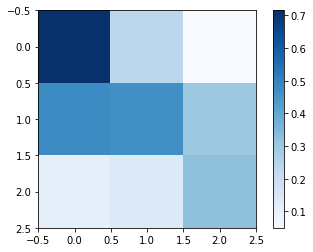

In [21]:
np.random.seed(794)
sampling_n = 210
init_idx = np.random.choice(len(trainX), sampling_n, replace=False )
rfc = RandomForestClassifier()
train_and_mapper(rfc, [trainX[init_idx], trainy[init_idx]], [testX, testy])